In [1]:
import sys
assert sys.version_info[0] >= 3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Init auth log data

In [2]:
%matplotlib inline
with open('../data/auth.log') as f:
    init_data = f.read().split('\n')

In [3]:
example = [x for x in init_data if 'user=root' in x][0]
example

'Mar 29 23:18:19 ip-10-77-20-248 sshd[6402]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=218.60.136.106  user=root'

In [4]:
'Mar 29 19:30:18 ip-10-77-20-248 sshd[5743]: Failed password for elastic_user_4 from 24.151.103.17 port 52124 ssh2'

'Mar 29 19:30:18 ip-10-77-20-248 sshd[5743]: Failed password for elastic_user_4 from 24.151.103.17 port 52124 ssh2'

## Create logs template 

In [5]:
template = '{:%b %d %H:%M:%S} {} sshd[1234]: Failed password for {} from {} port 1234 ssh2'

In [6]:
d = datetime(2018,3,10,10,45,10)
hostname = 'my-host-1-2-3-4'
ip = '192.168.10.1'
user = 'lab_user_1'

In [7]:
print(d,hostname,ip,user)

2018-03-10 10:45:10 my-host-1-2-3-4 192.168.10.1 lab_user_1


In [8]:
template.format(d,hostname,user,ip)

'Mar 10 10:45:10 my-host-1-2-3-4 sshd[1234]: Failed password for lab_user_1 from 192.168.10.1 port 1234 ssh2'

##  Create time index generator and df 

In [9]:
def create_time_index(start_date='22/3/2018 12:43:23',
                      end_date='30/3/2018',
                      period_minutes=120, #period in minutes
                      noise_minutes=10): #noise in minutes
    
    period_minutes=int(period_minutes)
    assert period_minutes>0
    
    noise_minutes = int(noise_minutes)
    assert noise_minutes>0

    dates = pd.date_range(start_date,end_date,freq='{}T'.format(period_minutes))
    dates += pd.Series([pd.Timedelta(str(int(x))+'m') for x in np.random.normal(0, noise_minutes, dates.shape)])
    return dates

In [10]:
def create_df(time_index, host='my-host-1', ip='192.168.0.1', user='lab_user1'):
    df = pd.DataFrame([[host,ip,user] for _ in time_index],
                      columns=['host','ip','user'],
                      index=time_index)
    return df

### Examples

In [11]:
create_time_index('1/27/2016 14:23:23','1/28/2016 16:23:23',5,1)

0     2016-01-27 14:22:23
1     2016-01-27 14:29:23
2     2016-01-27 14:33:23
3     2016-01-27 14:39:23
4     2016-01-27 14:43:23
5     2016-01-27 14:47:23
6     2016-01-27 14:52:23
7     2016-01-27 14:58:23
8     2016-01-27 15:03:23
9     2016-01-27 15:08:23
10    2016-01-27 15:13:23
11    2016-01-27 15:19:23
12    2016-01-27 15:22:23
13    2016-01-27 15:28:23
14    2016-01-27 15:33:23
15    2016-01-27 15:37:23
16    2016-01-27 15:43:23
17    2016-01-27 15:47:23
18    2016-01-27 15:52:23
19    2016-01-27 15:59:23
20    2016-01-27 16:03:23
21    2016-01-27 16:08:23
22    2016-01-27 16:13:23
23    2016-01-27 16:20:23
24    2016-01-27 16:23:23
25    2016-01-27 16:28:23
26    2016-01-27 16:33:23
27    2016-01-27 16:38:23
28    2016-01-27 16:43:23
29    2016-01-27 16:48:23
              ...        
283   2016-01-28 13:58:23
284   2016-01-28 14:03:23
285   2016-01-28 14:08:23
286   2016-01-28 14:13:23
287   2016-01-28 14:18:23
288   2016-01-28 14:23:23
289   2016-01-28 14:29:23
290   2016-0

In [12]:
every_24h_noisy = create_time_index('2/1/2016','2/14/2016',24*60,5*60)
df1 = create_df(every_24h_noisy,ip='192.168.0.24',user='lab_user_A')

every_24h = create_time_index('2/1/2016','2/14/2016',24*60,10)
df2 = create_df(every_24h,ip='192.168.0.2',user='lab_user_B')

every_12h = create_time_index('2/1/2016','2/14/2016',12*60,60)
df3 = create_df(every_12h,ip='192.168.0.10',user='lab_user_C')

every_1h = create_time_index('2/1/2016','2/14/2016',1*60,10)
df4 = create_df(every_1h,ip='192.168.0.124',user='lab_user_A')

### Concat data and plot

In [13]:
all_dfs = pd.concat([df1,df2,df3,df4])
all_dfs.sort_index(inplace=True)
all_dfs.head()

,host,ip,user
2016-01-31 16:10:00,my-host-1,192.168.0.24,lab_user_A
2016-01-31 23:14:00,my-host-1,192.168.0.10,lab_user_C
2016-01-31 23:50:00,my-host-1,192.168.0.2,lab_user_B
2016-02-01 00:16:00,my-host-1,192.168.0.124,lab_user_A
2016-02-01 00:57:00,my-host-1,192.168.0.124,lab_user_A


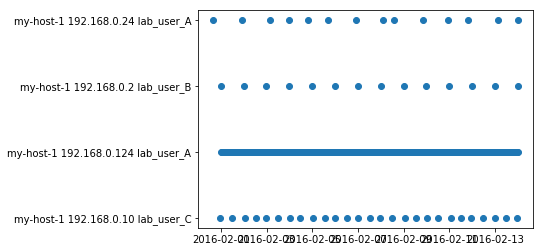

In [14]:
plt.plot_date(all_dfs.index,[' '.join(x) for x in all_dfs.values])

## Generate Examples with anomalies

In [15]:
anomalus_df = create_time_index('2/5/2016 12:00:00','2/6/2016 12:00:00',period_minutes=3*60,noise_minutes=20)
# same info as the 'every 24h df'
df_an = create_df(anomalus_df,ip='192.168.0.2',user='lab_user_B')

In [16]:
all_dfs = pd.concat([all_dfs,df_an])
all_dfs.sort_index(inplace=True)
all_dfs.head()

,host,ip,user
2016-01-31 16:10:00,my-host-1,192.168.0.24,lab_user_A
2016-01-31 23:14:00,my-host-1,192.168.0.10,lab_user_C
2016-01-31 23:50:00,my-host-1,192.168.0.2,lab_user_B
2016-02-01 00:16:00,my-host-1,192.168.0.124,lab_user_A
2016-02-01 00:57:00,my-host-1,192.168.0.124,lab_user_A


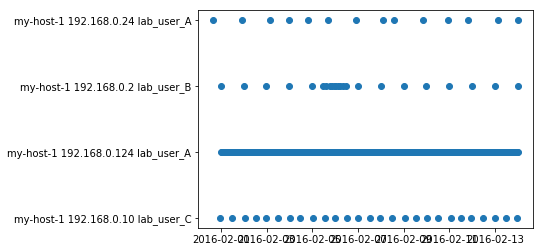

In [17]:
plt.plot_date(all_dfs.index,[' '.join(x) for x in all_dfs.values])

## Everything under one function

In [18]:
def generate_events(start_timedate_us_format ='3/22/2016 12:00:23',
                   end_timedate_us_format = '3/28/2016 21:12:43',
                   period_in_minutes=3*60,
                   noise_std_in_minutes=20,
                   host='my-host-1',
                   ip='192.168.0.1',
                   user='test_lab_user'
                  ):
    df_index = create_time_index(start_date = start_timedate_us_format,
                                 end_date = end_timedate_us_format,
                                 period_minutes = period_in_minutes,
                                 noise_minutes = noise_std_in_minutes)
    
    return_df = create_df(df_index,
                          host=host,
                          ip=ip,
                          user=user)    
        
    return return_df

def generate_events_from_list(list_of_settings):
    dfs_list = [generate_events(*settings) for settings in list_of_settings]
    
    all_dfs = pd.concat(dfs_list)
    all_dfs.sort_index(inplace=True)
    
    return(all_dfs)

def plot_dates_categorical(dfs):
    return plt.plot_date(dfs.index,[' '.join(x) for x in dfs.values])

In [19]:
settings = [
    ('1/1/2016', '1/30/2016',24*60,60,'host_1','10.10.24.1','lab_user1'),
    ('1/12/2016','1/15/2016',3*60,20,'host_1', '10.10.24.1','lab_user1'),
    ('1/25/2016','1/27/2016',1*60,20,'host_1', '10.10.24.1','lab_user1'),
    ('1/12/2016','1/15/2016',1*60,10,'host_1', '10.10.1.10','lab_user2'),
    ('1/5/2016', '1/17/2016',20,   2,'host_1', '10.10.1.1', 'lab_user2'),
    ('1/2/2016', '1/28/2016',12*60,30,'host_1','10.10.1.12','lab_user3'),
    ('1/4/2016', '1/5/2016',2*60,10,'host_1',  '10.10.1.12','lab_user3')]

In [20]:
all_data = generate_events_from_list(settings)

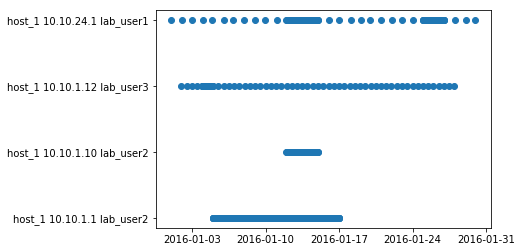

In [21]:
plot_dates_categorical(all_data)

## Export as logs

In [22]:
temp_data = all_data[:4]

In [23]:
temp_data

,host,ip,user
2016-01-01 00:03:00,host_1,10.10.24.1,lab_user1
2016-01-01 23:40:00,host_1,10.10.1.12,lab_user3
2016-01-01 23:57:00,host_1,10.10.24.1,lab_user1
2016-01-02 11:27:00,host_1,10.10.1.12,lab_user3


In [24]:
template = '{:%b %d %H:%M:%S} {} sshd[1234]: Failed password for {} from {} port 1234 ssh2'

In [25]:
for row in temp_data.iterrows():
    print(template.format(row[0],row[1]['host'],row[1]['user'],row[1]['ip']))
    print('---')

Jan 01 00:03:00 host_1 sshd[1234]: Failed password for lab_user1 from 10.10.24.1 port 1234 ssh2
---
Jan 01 23:40:00 host_1 sshd[1234]: Failed password for lab_user3 from 10.10.1.12 port 1234 ssh2
---
Jan 01 23:57:00 host_1 sshd[1234]: Failed password for lab_user1 from 10.10.24.1 port 1234 ssh2
---
Jan 02 11:27:00 host_1 sshd[1234]: Failed password for lab_user3 from 10.10.1.12 port 1234 ssh2
---


In [26]:
logs = []
for row in temp_data.iterrows():
    logs.append(template.format(row[0],row[1]['host'],row[1]['user'],row[1]['ip']))

In [27]:
logs

['Jan 01 00:03:00 host_1 sshd[1234]: Failed password for lab_user1 from 10.10.24.1 port 1234 ssh2',
 'Jan 01 23:40:00 host_1 sshd[1234]: Failed password for lab_user3 from 10.10.1.12 port 1234 ssh2',
 'Jan 01 23:57:00 host_1 sshd[1234]: Failed password for lab_user1 from 10.10.24.1 port 1234 ssh2',
 'Jan 02 11:27:00 host_1 sshd[1234]: Failed password for lab_user3 from 10.10.1.12 port 1234 ssh2']

In [28]:
def save_as_log_file(filename='temp_logs.log',dataframe=None):
    logs = []
    for row in dataframe.iterrows():
        logs.append(template.format(row[0],row[1]['host'],row[1]['user'],row[1]['ip']))    
    
    with open(filename,'w') as f:
        f.writelines([l+'\n' for l in logs])

    print('Saved to '+filename)
    print('Done')
    

In [29]:
save_as_log_file('../data/testtest.log',temp_data)

Saved to ../data/testtest.log
Done


###  Save the generated usecases

In [30]:
save_as_log_file('../data/4cases.log',all_data)

Saved to ../data/4cases.log
Done
